# Course 4 - Project - Part 8: Convolutional neural network

<a name="top-8"></a>
This notebook is concerned with *Part 8: Convolutional neural network*.

**Contents:**
* [Step 0: Loading data](#step-8.0)
* [Step 1: Convolutional neural network](#step-8.1)

## Step 0: Loading data<a name="step-7.0"></a> ([top](#top-7))
---

We begin with some imports.

In [2]:
# Standard library.
import pathlib
import typing as T

# 3rd party.
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Project.
import utils

We load the datasets with the extracted high-level features.

In [3]:
separator = ''.center(80, '-')

path_train = pathlib.Path.cwd() / 'data' / 'swissroads-features-train.npz'
data_train = utils.load(path_train)
print(separator)
print(f'Dataset: train\n{utils.info(data_train)}')

path_valid = pathlib.Path.cwd() / 'data' / 'swissroads-features-valid.npz'
data_valid = utils.load(path_valid)
print(separator)
print(f'Dataset: valid\n{utils.info(data_valid)}')

path_test = pathlib.Path.cwd() / 'data' / 'swissroads-features-test.npz'
data_test = utils.load(path_test)
print(separator)
print(f'Dataset: test\n{utils.info(data_test)}')

--------------------------------------------------------------------------------
Dataset: train
data: shape=(280, 224, 224, 3), dtype=float32
label_idxs: shape=(280,), dtype=int64
label_strs: shape=(6,), dtype=<U10
names: shape=(280,), dtype=<U19
features: shape=(280, 1280), dtype=float32
--------------------------------------------------------------------------------
Dataset: valid
data: shape=(139, 224, 224, 3), dtype=float32
label_idxs: shape=(139,), dtype=int64
label_strs: shape=(6,), dtype=<U10
names: shape=(139,), dtype=<U19
features: shape=(139, 1280), dtype=float32
--------------------------------------------------------------------------------
Dataset: test
data: shape=(50, 224, 224, 3), dtype=float32
label_idxs: shape=(50,), dtype=int64
label_strs: shape=(6,), dtype=<U10
names: shape=(50,), dtype=<U19
features: shape=(50, 1280), dtype=float32


In [4]:
label_strs = data_train['label_strs']  # Same for all data sets.
assert (
    np.all(data_train['label_strs'] == data_valid['label_strs']) and
    np.all(data_train['label_strs'] == data_test['label_strs'])
)

X_train = data_train['data']
y_train = data_train['label_idxs']
F_train = data_train['features']
N_train = data_train['names']

X_valid = data_valid['data']
y_valid = data_valid['label_idxs']
F_valid = data_valid['features']
N_valid = data_train['names']

X_test = data_test['data']
y_test = data_test['label_idxs']
F_test = data_test['features']
N_test = data_test['names']

We will fix the seed for the PRNG in order to make computations deterministic.

In [5]:
RANDOM_SEED = 0

## Step 1: Convolutional neural network<a name="step-8.1"></a> ([top](#top-8))
---

We begin with some imports.

In [16]:
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import ParameterGrid
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import activations
from tensorflow.keras import initializers
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers

As a baseline, we build the model from _Subject 08 - Unit 06_. The only change is that we increase the number of hidden neurons from 256 to 1024.

In [17]:
def build_model(input_shape: T.Tuple[int, int, int],
                dropout_rate: float = 0.5,
                l2_alpha: float=0.01):
    """\
    Builds, compiles and returns a Keras model.

    .. seealso:: https://keras.io/scikit-learn-api/
    """    
    # Create model.
    model = keras.Sequential()

    # Input layer with ? x ? x 3 RGB images.
    model.add(layers.InputLayer(input_shape=input_shape))
    
    #
    # 2 Convolutional/max-pooling layers.
    #
              
    # Convolutional layer - 64 filters, kernel: 5 x 5, stride: 2 x 2, padding: "same", activation: ReLU.
    model.add(layers.Conv2D(filters=64, kernel_size=5, strides=2, padding='same', activation='relu'))

    # Maxpool layer - pool-size: 2 x 2, strides: 2 x 2, padding: "same".
    model.add(layers.MaxPooling2D(pool_size=2, strides=2, padding='same'))
              
    # Convolutional layer - 64 filters, kernel: 3 x 3, stride: 1 x 1, padding: "same", activation: ReLU.
    model.add(layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
    
    # Maxpool layer - pool-size: 2 x 2, stride: 2 x 2, padding: "same".
    model.add(layers.MaxPooling2D(pool_size=2, strides=2, padding='same'))

    #
    # Dropout, 2 fully connected layers.
    #
    
    model.add(layers.Flatten())     
    model.add(layers.Dropout(dropout_rate, seed=RANDOM_SEED))

    model.add(layers.Dense(
        units=1024, activation='relu',
        kernel_initializer=initializers.VarianceScaling(scale=2.0, seed=RANDOM_SEED),
        kernel_regularizer=keras.regularizers.l2(l=l2_alpha)))

    # Output layer.
    model.add(layers.Dense(
        units=6, activation='softmax',
        kernel_initializer=initializers.VarianceScaling(scale=1.0, seed=RANDOM_SEED),
        kernel_regularizer=keras.regularizers.l2(l=l2_alpha)))

    # Compile the model.
    model.compile(
        optimizer=optimizers.Adam(),  # use defaults
        loss=losses.categorical_crossentropy,
        metrics=['acc']
    )

    return model

### Training on _train_ only

We begin with some imports.

In [19]:
# 3rd party.
from tensorflow.keras.callbacks import History
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Note:** In order to reduce the number of parameters in the classifier part of the model, we decide to resize images from 256 x 256 pixels down to 128 x 128 pixels. Since the image is resized but the kernel sizes stays the same, must also impact the NN part of the model.

In [20]:
input_shape_2d = (128, 128)
input_shape = tuple([*input_shape_2d, 3])

We apply the following data augmentations.

In [21]:
AUGMENTATIONS = dict(
    rotation_range=15,  # ±15 degrees
    width_shift_range=0.15,  # ±15%
    height_shift_range=0.15,  # ±15%
    brightness_range=(0.75, 1.25),  # 75% (darker) to 125% (brighter)
    zoom_range=(0.75, 1.25),  # 75% (zoom in) to 125% (zoom out)
    fill_mode='nearest',
    horizontal_flip=True
)

In [22]:
# Training, validation and test sets.
base_path = pathlib.Path.cwd() / 'data' / 'swissroads'
assert base_path.is_dir()

**Note:** For the the validation set, we use the generator that does _not_ apply augmentations.

In [23]:
def plot_learning_curves(history):
    """\
    Plosts the learning curves.
    """
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    # Plot loss values.
    ax1.set_title('loss: {:.4f}'.format(history.history['val_loss'][-1]))
    ax1.plot(history.history['val_loss'], label='validation')
    ax1.plot(history.history['loss'], label='training')
    ax1.legend()

    # Plot accuracy values.
    ax2.set_title('accuracy: {:.2f}%'.format(history.history['val_acc'][-1]*100))
    ax2.plot(history.history['val_acc'], label='validation')
    ax2.plot(history.history['acc'], label='training')
    ax2.legend()

    plt.show()

In [24]:
def train_and_evaluate(model: keras.Model) -> T.Tuple[History, T.Mapping[str, float]]:

    # Image generator with augmentations for training.
    train_generator = ImageDataGenerator(rescale=1/255, **augmentations)
    # Image generator without augmentations for validation and test.
    test_generator = ImageDataGenerator(rescale=1/255)

    train_set = train_generator.flow_from_directory(
        base_path / 'train', batch_size=32, target_size=input_shape_2d, shuffle=True, seed=RANDOM_SEED, interpolation='bicubic')
    valid_set = test_generator.flow_from_directory(
        base_path / 'valid', batch_size=32, target_size=input_shape_2d, shuffle=False, interpolation='bicubic')
    test_set = test_generator.flow_from_directory(
        base_path / 'test', batch_size=32, target_size=input_shape_2d, shuffle=False, interpolation='bicubic')
    
    # Trick: end training when accuracy stops improving (optional).
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

    # Train the model.
    history = model.fit_generator(
        generator=train_set, validation_data=valid_set, epochs=100, callbacks=[early_stopping])
    
    # Evaluate the model.
    results = dict(zip(model.metrics_names, model.evaluate_generator(test_set)))
    
    return history, results

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dropout (Dropout)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              16778240  
__________

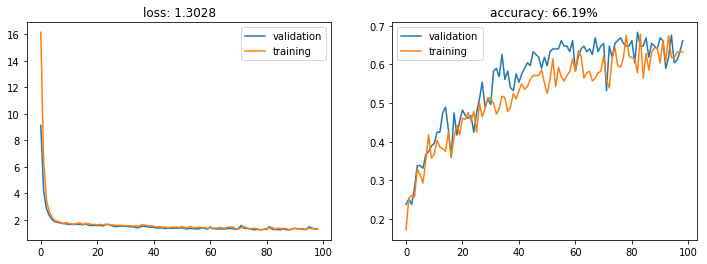

{'loss': 1.4672832250595094, 'acc': 0.5800000047683715}


In [25]:
# Try to make computations deterministic.
utils.reset_seeds()

# Build and train the model.
model = build_model(input_shape)
model.summary()

# Train and evaluate the model.
history, results = train_and_evaluate(model)

# Plot the learning curves.
plot_learning_curves(history)
print(results)

### Large train set

Having found a suitable design and set of hyperparameters, we want to figure out if we can slightly increase the accuracy by training the model on a larger training set obtained by grouping the current training and validation sets.

In [27]:
def train_and_evaluate_large(model: keras.Model) -> T.Tuple[History, T.Mapping[str, float]]:

    # Image generator with augmentations for training.
    train_generator = ImageDataGenerator(rescale=1/255, **augmentations)
    # Image generator without augmentations for validation and test.
    test_generator = ImageDataGenerator(rescale=1/255)

    train_set = train_generator.flow_from_directory(
        base_path / 'train_large', batch_size=32, target_size=input_shape_2d, shuffle=True, seed=RANDOM_SEED, interpolation='bicubic')
    test_set = test_generator.flow_from_directory(
        base_path / 'test', batch_size=32, target_size=input_shape_2d, shuffle=False, interpolation='bicubic')
    
#     # Trick: end training when accuracy stops improving (optional).
#     early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

    # Train the model.
    history = model.fit_generator(
        generator=train_set, epochs=100)
#         generator=train_set, validation_data=valid_set, epochs=100, callbacks=[early_stopping])
    
    # Evaluate the model.
    results = dict(zip(model.metrics_names, model.evaluate_generator(test_set)))
    
    return history, results

In [29]:
# Try to make computations deterministic.
utils.reset_seeds()

# Build and train the model.
model_large = build_model(input_shape)
model_large.summary()

# Train and evaluate the model.
history_large, results_large = train_and_evaluate_large(model_large)

# Plot the learning curves.
# plot_learning_curves(history_large)
print(results_large)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 64, 64, 64)        4864      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16384)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              16778240  
__________

In [ ]:
len(train_set) * 32

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot loss values
ax1.set_title('loss: {:.4f}'.format(history.history['loss'][-1]))
ax1.plot(history.history['loss'], label='validation')
ax1.plot(history.history['loss'], label='training')
ax1.legend()

# plot accuracy values
ax2.set_title('accuracy: {:.2f}%'.format(history.history['acc'][-1]*100))
ax2.plot(history.history['acc'], label='validation')
ax2.plot(history.history['acc'], label='training')
ax2.legend()

plt.show()

In [ ]:
X_train_large = np.concatenate([X_train, X_valid])
y_train_large = np.concatenate([y_train, y_valid])
F_train_large = np.concatenate([F_train, F_valid])
N_train_large = np.concatenate([N_train, N_valid])

In [ ]:
X_train_large.shape

In [ ]:
# 3rd party.
%matplotlib inline
import matplotlib.pyplot as plt
import PIL as pil

sample = X_train_large[0]
print(sample.shape, sample.min(), sample.max())

fix, ax = plt.subplots()
ax.imshow(sample)
plt.show()


def resize_image(source: np.ndarray, target_size) -> np.ndarray:
    """\
    Resizes an image, as a 224 x 224 x 3 NumPy array.
    """
    source_arr = np.clip(source * 255, 0, 255).astype('uint8')
    source_img = pil.Image.fromarray(source_arr)
    target_img = source_img.resize(target_size, pil.Image.BICUBIC)
    target_arr = np.asarray(target_img, dtype=np.float32)  # height x width x 3
    target = target_arr * 1/255
    return target


target = resize_image(sample, target_size=input_shape_2d)
print(target.shape, target.min(), target.max())

fix, ax = plt.subplots()
ax.imshow(target)
plt.show()

print(f'here: {X_train_large.shape}')

# for sample in X_train_large:
#     print(resize_image(sample, target_size=input_shape_2d).shape)
X_train_large_resized = np.concatenate([
    resize_image(sample, target_size=input_shape_2d)[np.newaxis, :, : :] for sample in X_train_large
])

print(f'here 2: {X_train_large_resized.shape}')

sample = X_train_large_resized[0]
print(sample.shape, sample.min(), sample.max())

fix, ax = plt.subplots()
ax.imshow(sample)
plt.show()

In [ ]:
base_path = pathlib.Path.cwd() / 'data' / 'swissroads'
assert base_path.is_dir()

separator = ''.center(80, '-')

path_train = base_path / 'train'
data_train_128 = datasetutils.load_dataset(path_train, target_size=(128, 128))
print(separator)
print(f'Dataset: train\n{utils.info(data_train_128)}')

path_valid = base_path / 'valid'
data_valid_128 = datasetutils.load_dataset(path_valid, target_size=(128, 128))
print(separator)
print(f'Dataset: valid\n{utils.info(data_valid_128)}')

path_test = base_path / 'test'
data_test_128 = datasetutils.load_dataset(path_test, target_size=(128, 128))
print(separator)
print(f'Dataset: test\n{utils.info(data_test_128)}')

In [ ]:
label_strs = data_train_128['label_strs']  # Same for all data sets.
assert (
    np.all(data_train_128['label_strs'] == data_valid_128['label_strs']) and
    np.all(data_train_128['label_strs'] == data_test_128['label_strs'])
)

X_train_128 = data_train_128['data']
y_train_128 = data_train_128['label_idxs']
N_train_128 = data_train_128['names']

X_valid_128 = data_valid_128['data']
y_valid_128 = data_valid_128['label_idxs']
N_valid_128 = data_train_128['names']

X_test_128 = data_test_128['data']
y_test_128 = data_test_128['label_idxs']
N_test_128 = data_test_128['names']

X_train_large_128 = np.concatenate([X_train_128, X_valid_128])
y_train_large_128 = np.concatenate([y_train_128, y_valid_128])
N_train_large_128 = np.concatenate([N_train_128, N_valid_128])

In [ ]:
input_shape_2d = (128, 128)
input_shape = tuple([*input_shape_2d, 3])

model = build_model(input_shape=input_shape)
model.summary()

# Create image generator
train_generator = ImageDataGenerator(
#     rescale=1/255, 
    # Augmentations:
    rotation_range=15,  # ±15 degrees
    width_shift_range=0.15,  # ±15%
    height_shift_range=0.15,  # ±15%
    brightness_range=(0.75, 1.25),  # 75% (darker) to 125% (brighter)
    zoom_range=(0.75, 1.25),  # 80% (zoom in) to 120% (zoom out)
    fill_mode='nearest',
    horizontal_flip=True
)

test_generator = ImageDataGenerator(
#     rescale=1/255
)

tmp = keras.utils.to_categorical(np.concatenate([y_train_large_128, y_test_128]), num_classes=6)
y_train_large_128_cat = tmp[:len(y_train_large_128)]
y_test_128_cat = tmp[len(y_train_large_128):]

# Training and test sets.
train_large_set_128 = train_generator.flow(
    X_train_large_128, y_train_large_128_cat, batch_size=32, shuffle=True, seed=RANDOM_SEED)
test_set_128 = test_generator.flow(
    X_test_128, y_test_128_cat, batch_size=32, shuffle=False)

In [ ]:
X_train_large_128.max()

In [ ]:
# Train model.
history = model.fit_generator(
    generator=train_large_set_128, steps_per_epoch=len(X_train_large_128) / 32, epochs=70)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot loss values
ax1.set_title('loss: {:.4f}'.format(history.history['loss'][-1]))
ax1.plot(history.history['loss'], label='validation')
ax1.plot(history.history['loss'], label='training')
ax1.legend()

# plot accuracy values
ax2.set_title('accuracy: {:.2f}%'.format(history.history['acc'][-1]*100))
ax2.plot(history.history['acc'], label='validation')
ax2.plot(history.history['acc'], label='training')
ax2.legend()

plt.show()

In [ ]:
results = list(zip(model.metrics_names, model.evaluate_generator(test_set_128)))
results